**Todas as cidades**

In [1]:
# Importando módulos internos
import geocov19_functions_results as fresults

# Importando módulos externos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statistics import mean
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [54]:
def return_tokens(df, column):
    
    all_tokens = []

    for index, row in df.iterrows():
        tokens = row[column]
        for token in tokens:
            all_tokens.append(token)

    return all_tokens

In [3]:
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [4]:
len(df)

1205718

In [5]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 09:32:32,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
1,2020-02-02 09:33:28,user_location,São Paulo,Sorocaba,RT @revistasuper: #SuperLidas A doença surgiu ...,0.0000,pt
2,2020-02-02 09:34:20,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
3,2020-02-02 09:38:24,user_location,Paraíba,João Pessoa,RT @lelispatricia: Olavo de Carvalho é o “guru...,-0.4767,pt
4,2020-02-02 09:39:50,user_location,São Paulo,Conchas,RT @da_goiabeira: Passam a vida criticando a c...,-0.3612,pt


Análises por período

In [6]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [7]:
top_cities = list(df.city.value_counts()[:70].index)
df_top_cities = df.loc[df['city'].isin(top_cities)]

In [8]:
cities = df_top_cities.groupby('city')

cities_cases_date = []

for city in cities['city']:

    city = city[0]   
    
    df_cases_city = df_cases_brasil.query('city == "'+city+'"')
    df_cases_city = df_cases_city.reset_index()
    df_cases_city = df_cases_city.drop(columns=['index'])
    
    if (len(df_cases_city) > 0):
    
        # Data do primeiro caso 
        first_case_date = df_cases_city.loc[0, 'date']

        # Data da primeira morte
        result = df_cases_city.query('last_available_deaths != "0"')
        
        if (len(result) > 0):
            first_death_date = df_cases_city.loc[min(result.index), 'date']
            
            if (first_death_date < '2020-05-01'):
                data = [city, first_case_date, first_death_date]
                cities_cases_date.append(data)

df_cities_cases_date = pd.DataFrame.from_dict(cities_cases_date)
df_cities_cases_date.columns = ['city', 'first_case_date', 'first_death_date']

df_cities_cases_date

,city,first_case_date,first_death_date
0,Aracaju,2020-03-14,2020-04-02
1,Belford Roxo,2020-03-26,2020-04-02
2,Belo Horizonte,2020-03-16,2020-03-30
3,Belém,2020-03-18,2020-04-06
4,Blumenau,2020-03-22,2020-05-05
...,...,...,...
62,Teresina,2020-03-19,2020-03-30
63,Uberlândia,2020-03-17,2020-04-03
64,Vila Velha,2020-03-19,2020-04-02
65,Vitória,2020-03-19,2020-04-03


**Análises por Período - Geral**

In [9]:
periodo1_mean = []
periodo2_mean = []
periodo3_mean = []
total_mean = []

tokens_neg = []
tokens_neg1 = []
tokens_neg2 = []
tokens_neg3 = []

tokens_pos = []
tokens_pos1 = []
tokens_pos2 = []
tokens_pos3 = []

max_tokens = 10
total_processed = 0

for index, row in df_cities_cases_date.iterrows():
    
    city = row['city']
    
    total_processed = total_processed + 1
    print('Processando', total_processed, 'de', len(df_cities_cases_date))
    
    df_city = df.query('city == "'+city+'"')
    df_city_mean = mean(df_city['score'])
    total_mean.append(df_city_mean)
    
    df_periodo1 = df_city.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case_date+' 00:00:00"')  
    df_periodo1_mean = mean(df_periodo1['score'])
    periodo1_mean.append(df_periodo1_mean)

    df_periodo2 = df_city.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
    df_periodo2_mean = mean(df_periodo2['score'])
    periodo2_mean.append(df_periodo2_mean)

    df_periodo3 = df_city.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
    df_periodo3_mean = mean(df_periodo3['score'])
    periodo3_mean.append(df_periodo3_mean)
    
    start = df_city['score'].describe()['min']
    end = df_city['score'].describe()['25%']
    
    tokens_city_neg = fresults.return_tokens_from_interval(df_city, start, end)
    tokens_city_neg1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
    tokens_city_neg2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
    tokens_city_neg3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
    
    tokens_neg.append(tokens_city_neg)
    tokens_neg1.append(tokens_city_neg1)
    tokens_neg2.append(tokens_city_neg2)
    tokens_neg3.append(tokens_city_neg3)
    
    start = df_city['score'].describe()['75%']
    end = df_city['score'].describe()['max']
    
    tokens_city_pos = fresults.return_tokens_from_interval(df_city, start, end)
    tokens_city_pos1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
    tokens_city_pos2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
    tokens_city_pos3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
    
    tokens_pos.append(tokens_city_pos)
    tokens_pos1.append(tokens_city_pos1)
    tokens_pos2.append(tokens_city_pos2)
    tokens_pos3.append(tokens_city_pos3)
    
df_cities_cases_date['total_mean'] = total_mean
df_cities_cases_date['periodo1_mean'] = periodo1_mean
df_cities_cases_date['periodo2_mean'] = periodo2_mean
df_cities_cases_date['periodo3_mean'] = periodo3_mean

df_cities_cases_date['tokens_neg'] = tokens_neg
df_cities_cases_date['tokens_neg1'] = tokens_neg1
df_cities_cases_date['tokens_neg2'] = tokens_neg2
df_cities_cases_date['tokens_neg3'] = tokens_neg3

df_cities_cases_date['tokens_pos'] = tokens_pos
df_cities_cases_date['tokens_pos1'] = tokens_pos1
df_cities_cases_date['tokens_pos2'] = tokens_pos2
df_cities_cases_date['tokens_pos3'] = tokens_pos3

Processando 1 de 67
Processando 2 de 67
Processando 3 de 67
Processando 4 de 67
Processando 5 de 67
Processando 6 de 67
Processando 7 de 67
Processando 8 de 67
Processando 9 de 67
Processando 10 de 67
Processando 11 de 67
Processando 12 de 67
Processando 13 de 67
Processando 14 de 67
Processando 15 de 67
Processando 16 de 67
Processando 17 de 67
Processando 18 de 67
Processando 19 de 67
Processando 20 de 67
Processando 21 de 67
Processando 22 de 67
Processando 23 de 67
Processando 24 de 67
Processando 25 de 67
Processando 26 de 67
Processando 27 de 67
Processando 28 de 67
Processando 29 de 67
Processando 30 de 67
Processando 31 de 67
Processando 32 de 67
Processando 33 de 67
Processando 34 de 67
Processando 35 de 67
Processando 36 de 67
Processando 37 de 67
Processando 38 de 67
Processando 39 de 67
Processando 40 de 67
Processando 41 de 67
Processando 42 de 67
Processando 43 de 67
Processando 44 de 67
Processando 45 de 67
Processando 46 de 67
Processando 47 de 67
Processando 48 de 67
P

In [10]:
df_cities_cases_date.head()

,city,first_case_date,first_death_date,total_mean,periodo1_mean,periodo2_mean,periodo3_mean,tokens_neg,tokens_neg1,tokens_neg2,tokens_neg3,tokens_pos,tokens_pos1,tokens_pos2,tokens_pos3
0,Aracaju,2020-03-14,2020-04-02,-0.050844,-0.031442,-0.029884,-0.057884,"[número, mortes, ultrapassa, 300, china, –, aj...","[número, mortes, ultrapassa, 300, china, –, aj...","[belivaldo, pede, bolsonaro, recursos, combate...","[@manueladavila, achava, histeria, primeira, m...","[@valoreconomico, banco, central, china, liber...","[@valoreconomico, banco, central, china, liber...","[#covid2019pt, @dhumanosbrasil, cobrem, prefei...","[@luizgonzagadel1, venceremos, graça, deus, in..."
1,Belford Roxo,2020-03-26,2020-04-02,0.006020,0.004702,-0.018114,0.009039,"[@artur_slo, opinião, acerca, realização, carn...","[@artur_slo, opinião, acerca, realização, carn...","[@bailedoantares, colocando, medo, todo, mundo...","[@gdthieves, lavem, mãos, solta, https://t.co/...","[sentiu, jkkkkkkkk, https://t.co/85twbvbre5, @...","[sentiu, jkkkkkkkk, https://t.co/85twbvbre5, @...","[@guipolemico, ja, deu, ja, fez, graça, @doraf...","[@rubronegro1985, notícia, urgente, descobrira..."
2,Belo Horizonte,2020-03-16,2020-03-30,-0.046287,-0.021647,-0.032389,-0.057413,"[@digital_explora, #china, #wuhan, 02/02, 2020...","[@digital_explora, #china, #wuhan, 02/02, 2020...","[i'm, so, bored, i, hate, this, i, hate, hate,...","[@miguelnicolelis, tragédia, anunciada, triste...","[chance, ir, china, barato, https://t.co/lav81...","[chance, ir, china, barato, https://t.co/lav81...","[@boudelaires, mineiro, deus, tô, tossindo, tô...","[@tiowiii, calma, ai, amado, verdade, ainda, @..."
3,Belém,2020-03-18,2020-04-06,-0.050215,-0.009508,-0.069118,-0.062285,"[tranquiliza, ter, terceira, guerra, mundial, ...","[tranquiliza, ter, terceira, guerra, mundial, ...","[vou, fazer, curso, online, ensinar, pessoas, ...","[quanta, dor, sofrimento, sinceros, pêsames, f...","[chega, rio, janeiro, vence, vasco, 3, x, 0, b...","[chega, rio, janeiro, vence, vasco, 3, x, 0, b...","[inacreditável, existem, pessoas, favoráveis, ...","[câmara, aprova, projeto, prevê, r, 600, mês, ..."
4,Blumenau,2020-03-22,2020-05-05,-0.030610,-0.022732,0.011250,-0.037439,"[faz, merda, bicho, ent, fuder, msm, https://t...","[faz, merda, bicho, ent, fuder, msm, https://t...","[@lacerda, gabi, brandt, nao, precisa, ter, me...","[@marianrinha, governador, sc, hoje, primeira,...","[tomara, pegue, trampando, caixa, brasileiro, ...","[tomara, pegue, trampando, caixa, brasileiro, ...","[#gartic, sala, bnufiqueemcasa, https://t.co/v...","[@hsgesser, @alexaguiarpoa, diante, circunstân..."


***
**Análises**

In [11]:
df_cities_neg = df_cities_cases_date.sort_values(by=['total_mean'], ascending=True)[:10]
df_cities_neg['city']

36               Oeiras
6     Bragança Paulista
31                Natal
29              Maringá
14               Cuiabá
38               Palmas
56           São Carlos
17            Fortaleza
22          João Pessoa
18              Goiânia
Name: city, dtype: object

In [12]:
df_cities_pos = df_cities_cases_date.sort_values(by=['total_mean'], ascending=False)[:10]
df_cities_pos['city']

1      Belford Roxo
34      Nova Iguaçu
12    Caxias do Sul
61        São Paulo
42     Ponta Grossa
11           Canoas
44      Porto Velho
26            Macaé
30    Montes Claros
57      São Gonçalo
Name: city, dtype: object

**Boxplots**

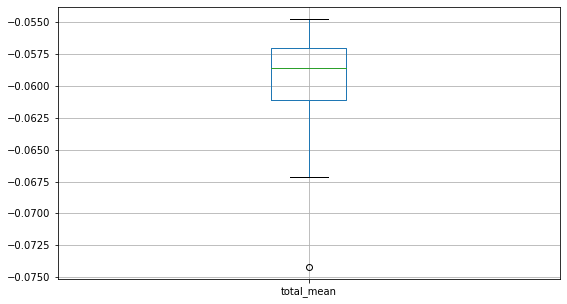

In [13]:
boxplot = df_cities_neg.boxplot(column=['total_mean'], grid=True, figsize=(9, 5))

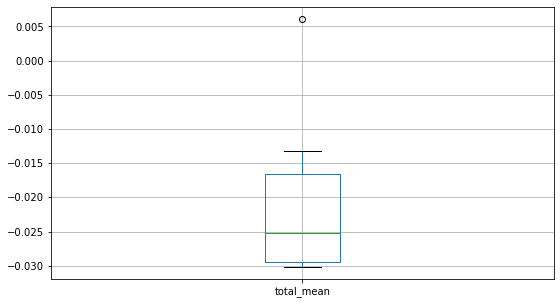

In [14]:
boxplot = df_cities_pos.boxplot(column=['total_mean'], grid=True, figsize=(9, 5))

**Gráfico de Barras**

In [15]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Cidades com menores médias de sentimentos

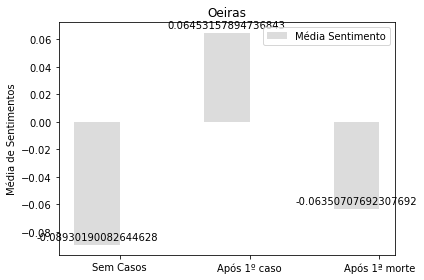

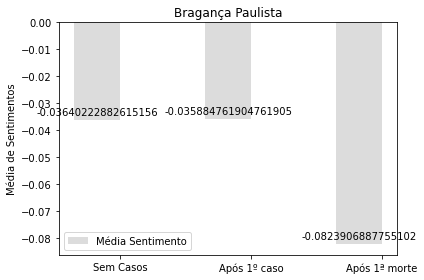

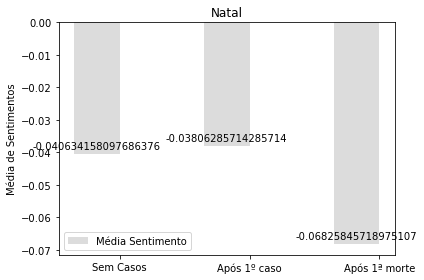

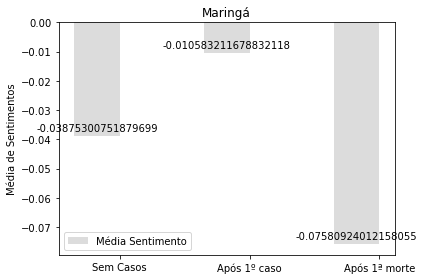

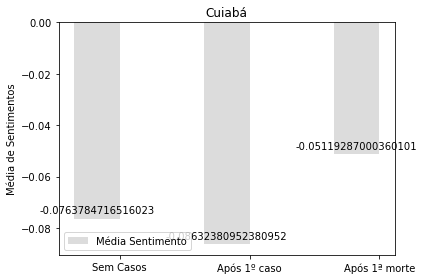

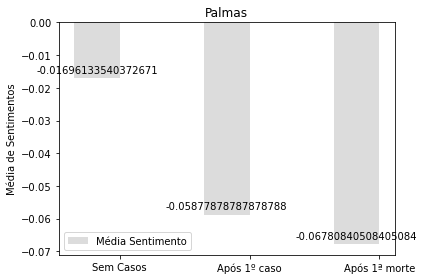

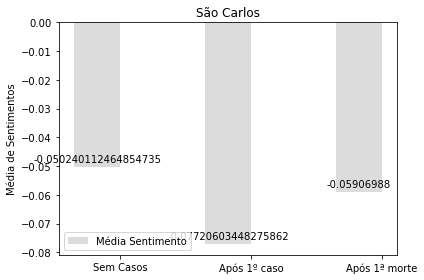

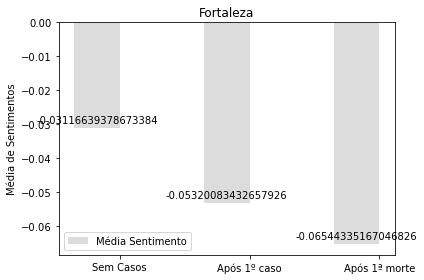

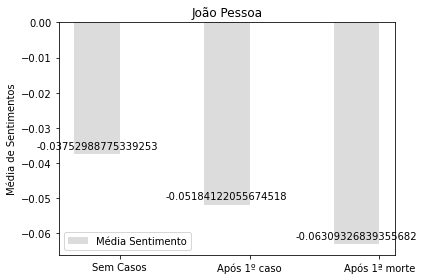

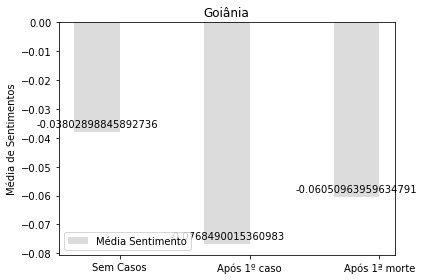

In [16]:
for index, row in df_cities_neg.iterrows():
    
    city = row['city']
    mean1 = row['periodo1_mean']
    mean2 = row['periodo2_mean']
    mean3 = row['periodo3_mean']

    labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
    y1 = [mean1, mean2, mean3]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Média de Sentimentos')
    ax.set_title(city)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1)

    fig.tight_layout()

    plt.show()

Cidades com maiores médias de sentimentos

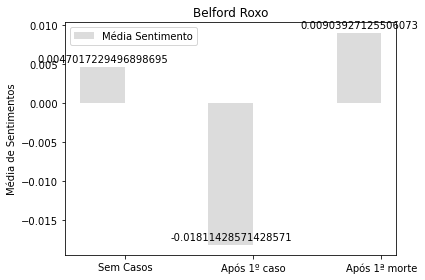

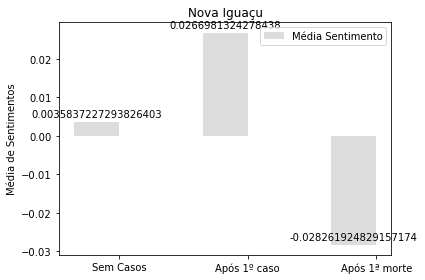

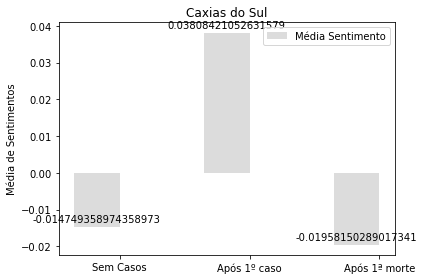

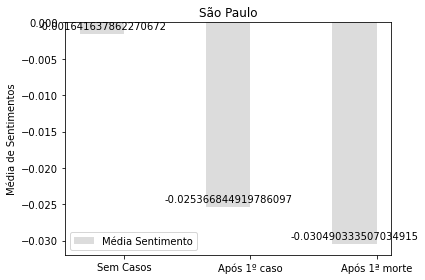

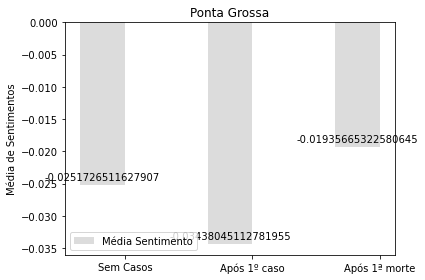

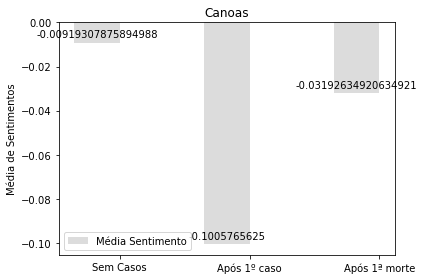

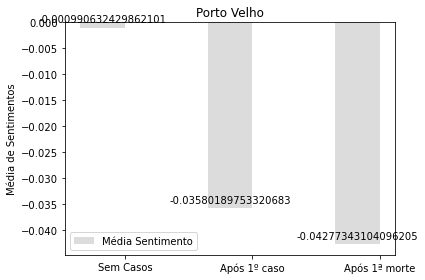

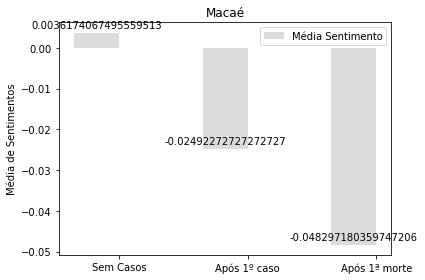

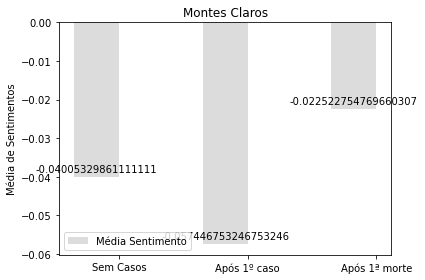

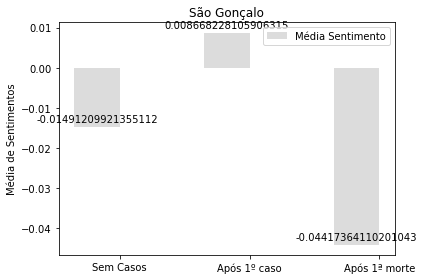

In [17]:
for index, row in df_cities_pos.iterrows():
    
    city = row['city']
    mean1 = row['periodo1_mean']
    mean2 = row['periodo2_mean']
    mean3 = row['periodo3_mean']

    labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
    y1 = [mean1, mean2, mean3]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Média de Sentimentos')
    ax.set_title(city)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1)

    fig.tight_layout()

    plt.show()

**Média de sentimento por dia**

In [61]:
def generate_daily_graphic(df, df_brasil):
    
    for index, row in df.iterrows():
    
        city = row['city']
        first_case_date = row['first_case_date']
        first_death_date = row['first_death_date']

        df_city = df_brasil.query('city == "'+city+'"')
        df_scores_city = fresults.building_dates_df(df_city, 'score')

        x = df_scores_city.created_at
        y = df_scores_city.score_mean

        color = 'dimgrey'

        label = 'Médias'
        xLabel = 'Data'
        yLabel = 'Médias'

        title = city

        fresults.generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, '2020-02-01', first_case_date, first_death_date)

Cidades com menores médias de sentimentos

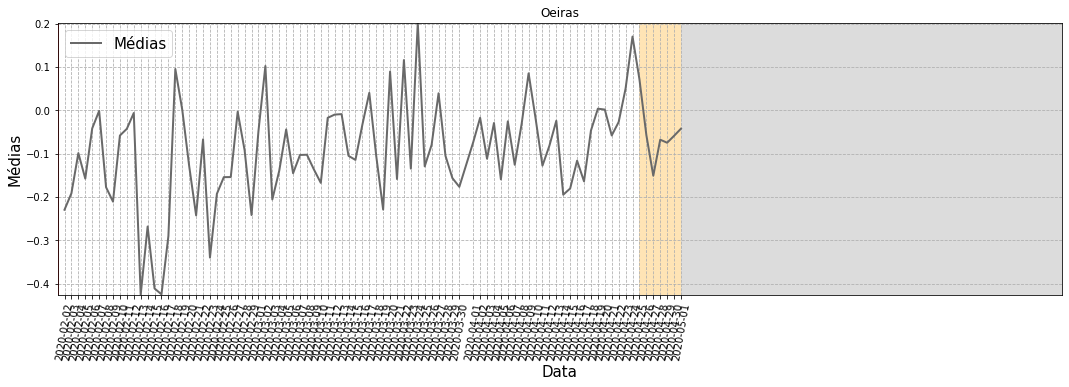

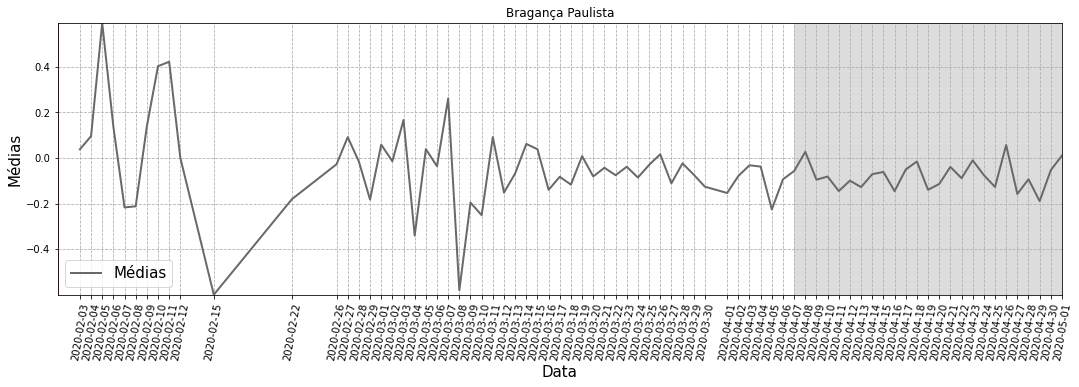

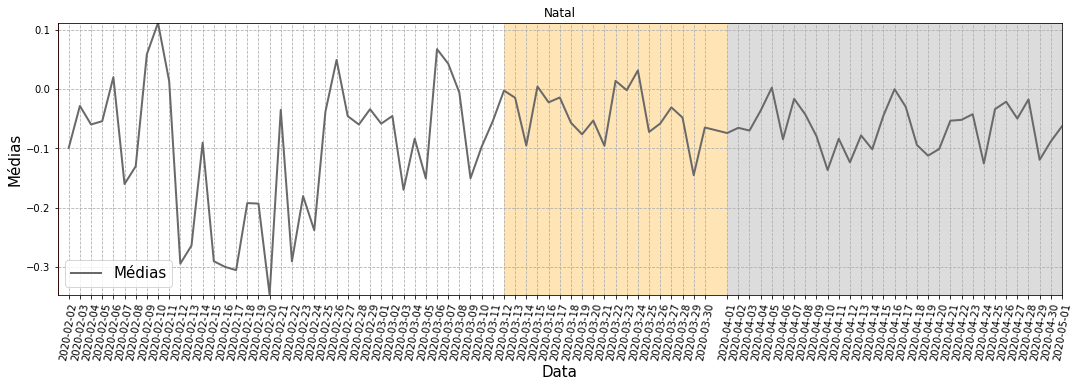

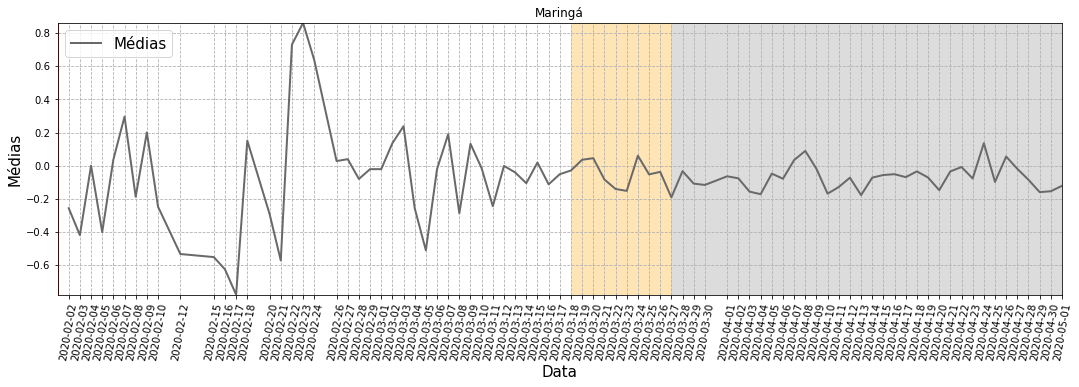

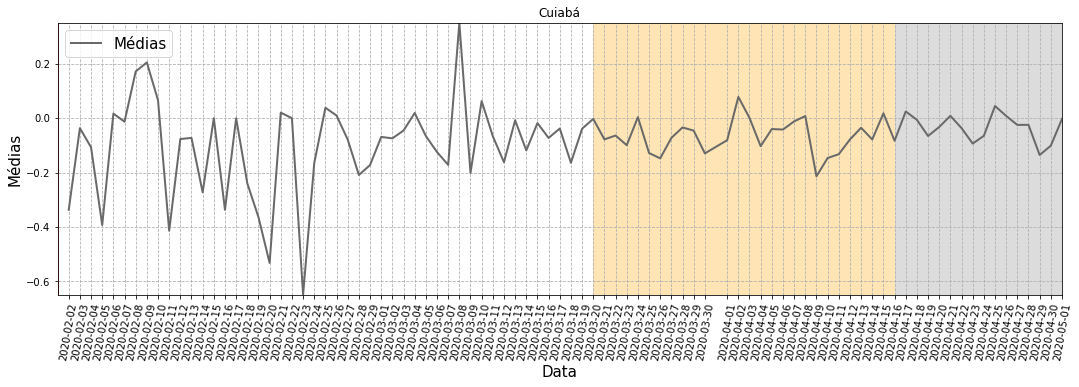

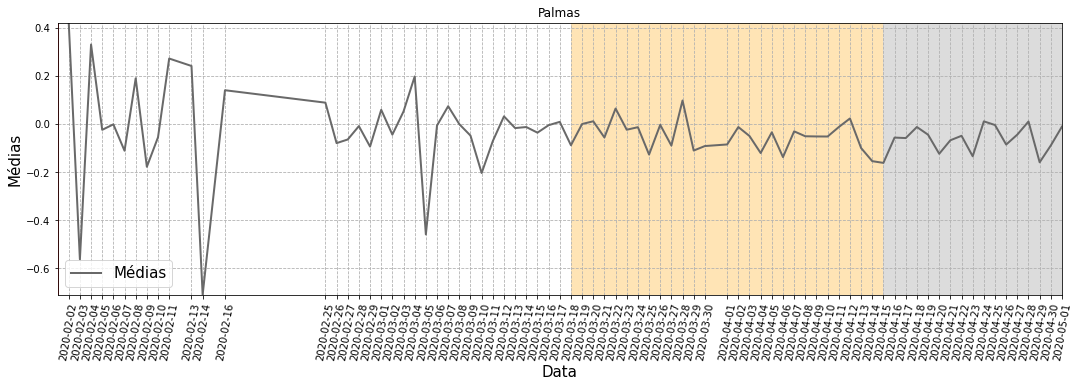

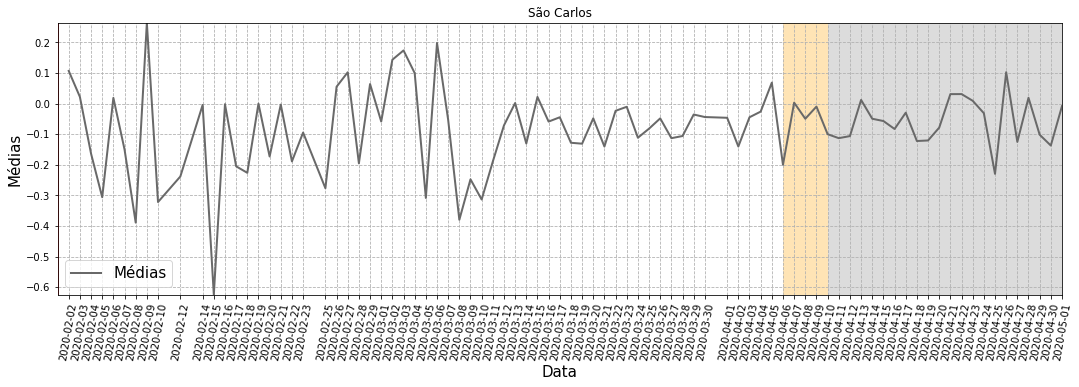

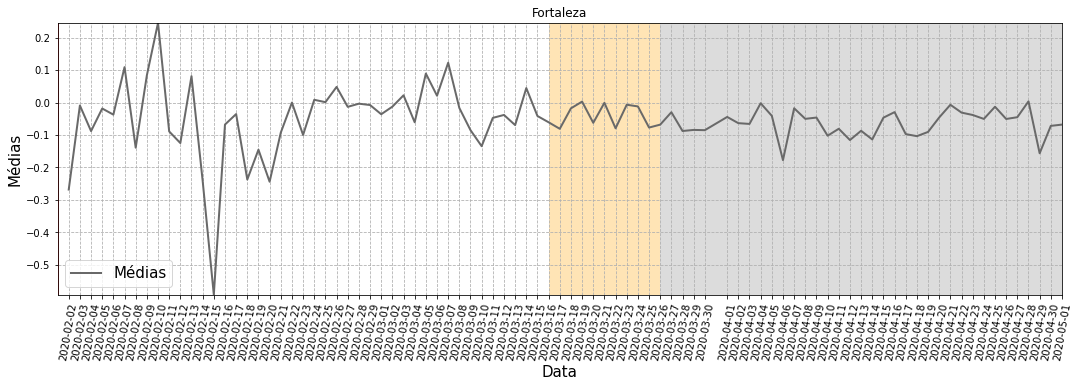

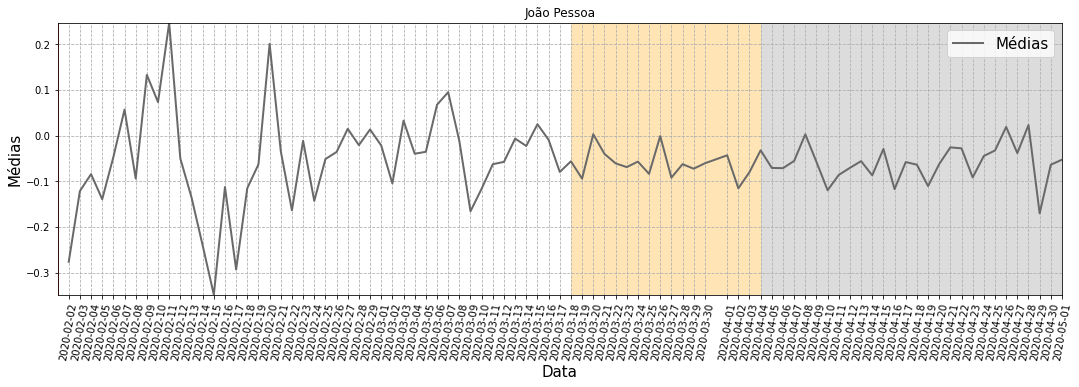

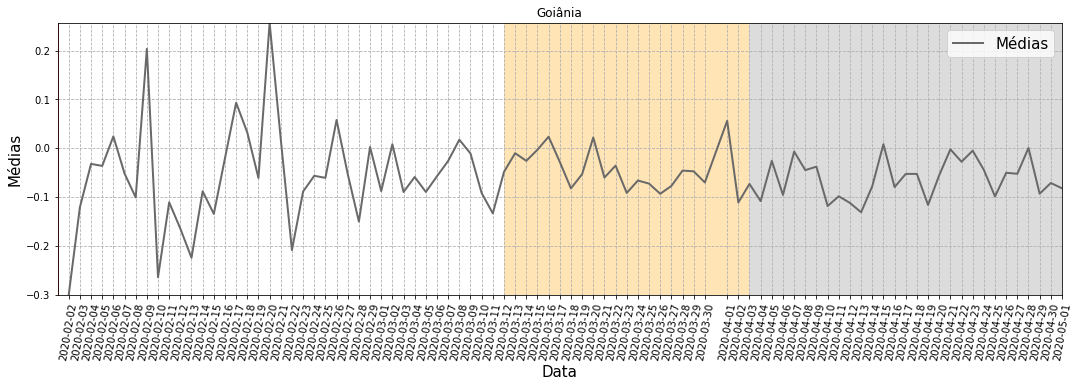

In [62]:
generate_daily_graphic(df_cities_neg, df)

Cidades com maiores médias de sentimentos

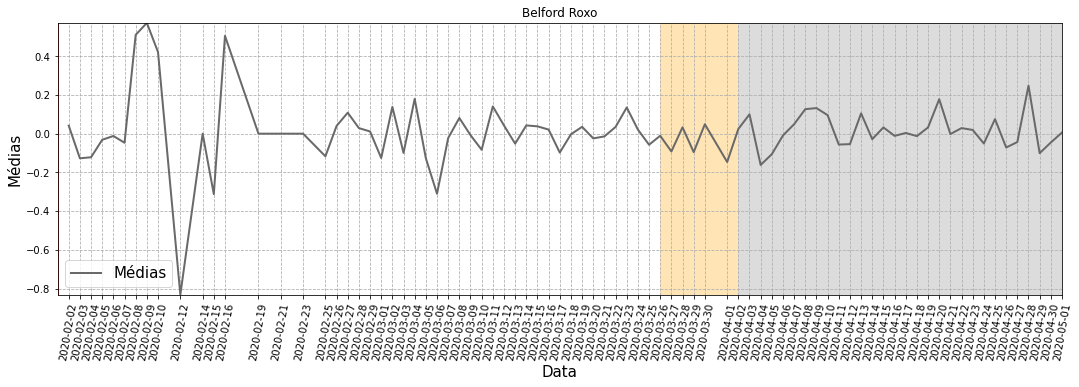

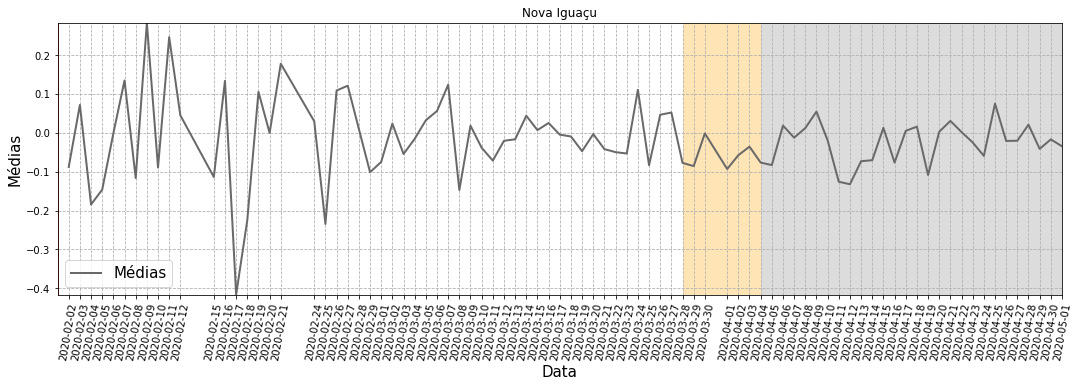

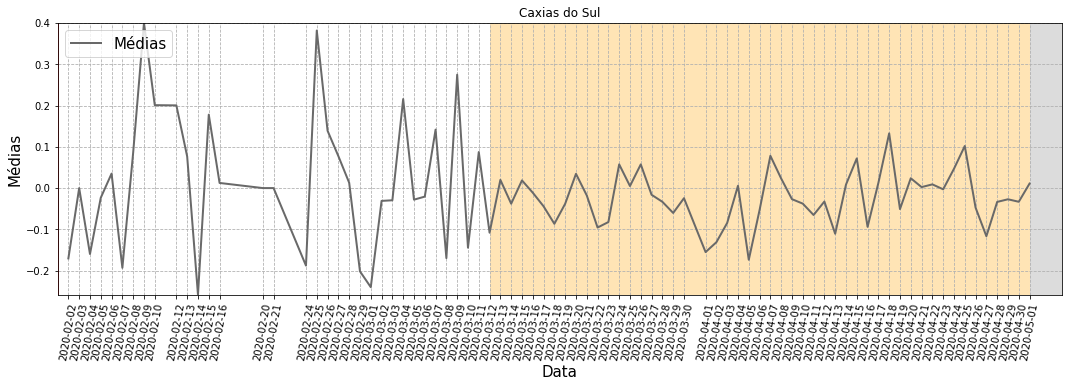

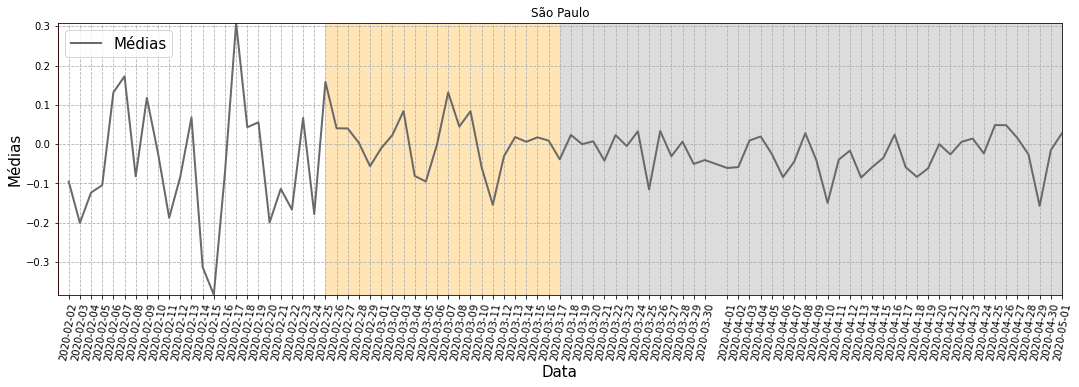

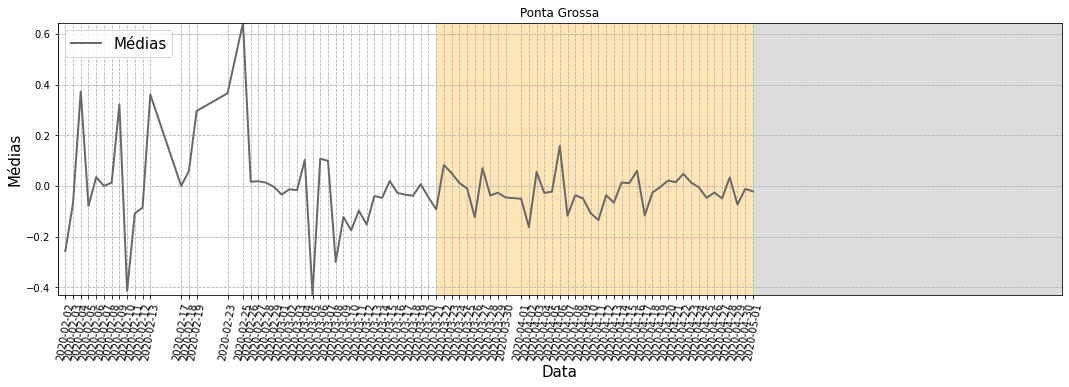

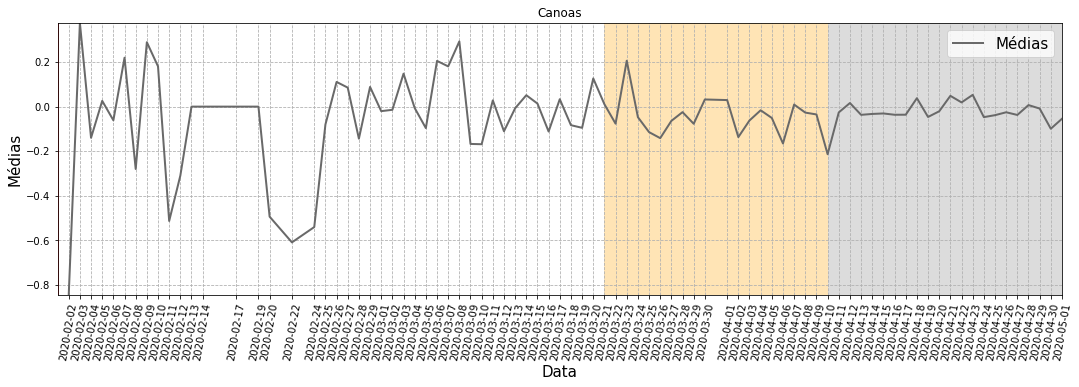

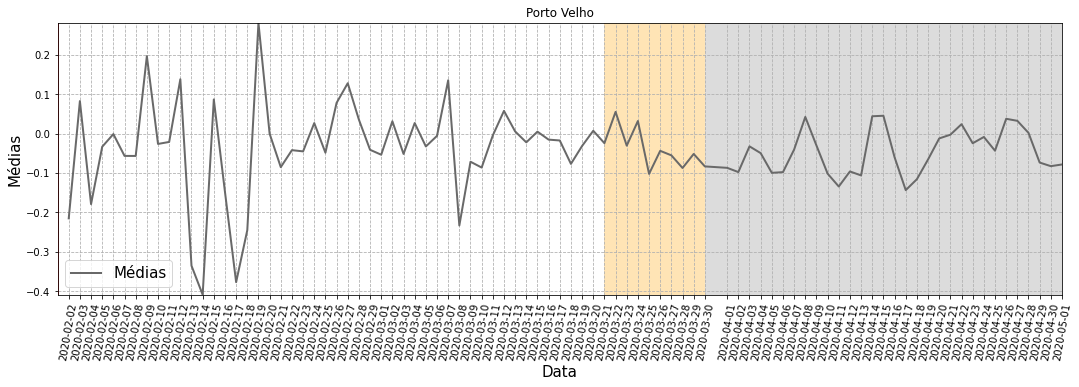

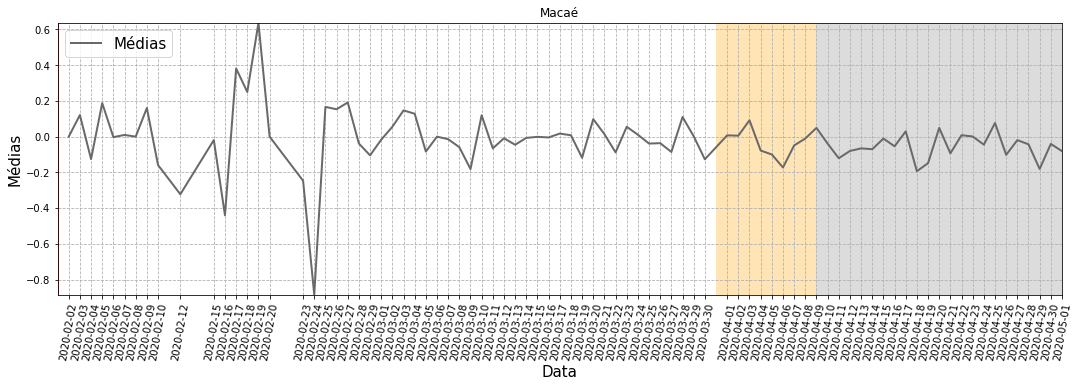

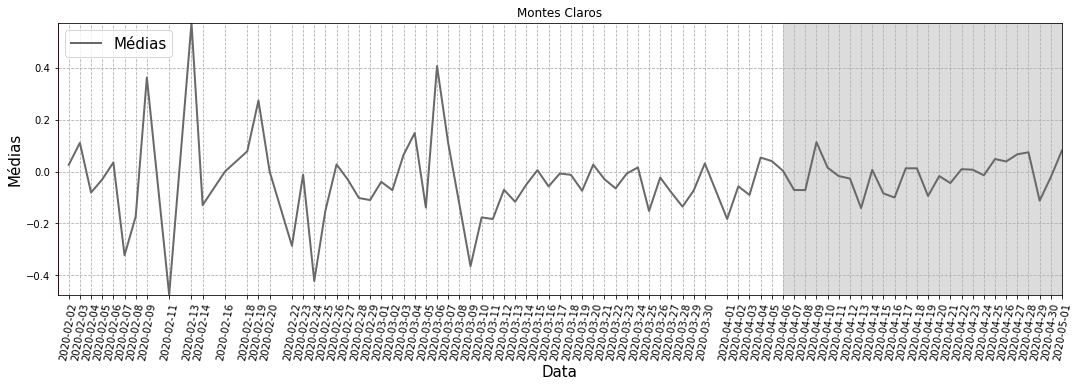

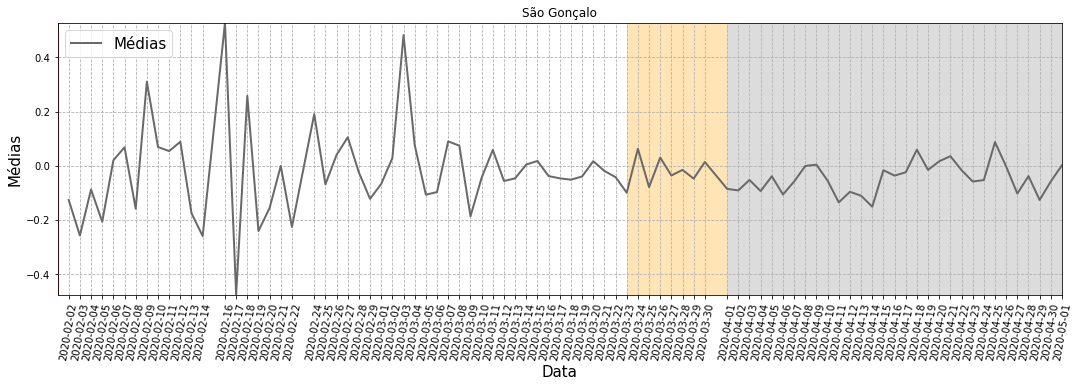

In [63]:
generate_daily_graphic(df_cities_pos, df)

**Palavras presentes nos tweets que mais influenciaram negativamente/positivamente**

Primeiro Período (Sem Casos)

- Cidades com menores médias de sentimentos

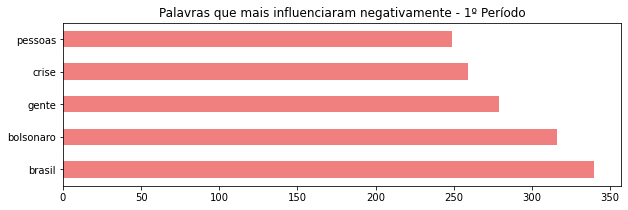

In [20]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg1')
fresults.generate_bar_from_tokens(all_tokens_neg, 5, 'lightcoral', 10, 3, title)

- Cidades com maiores médias de sentimentos

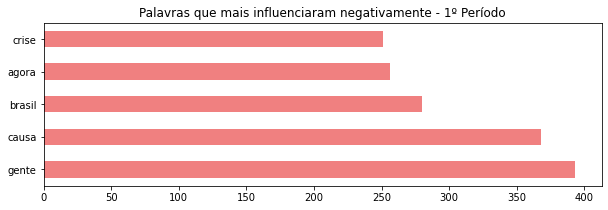

In [21]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg1')
fresults.generate_bar_from_tokens(all_tokens_neg, 5, 'lightcoral', 10, 3, title)

- Cidades com menores médias de sentimentos

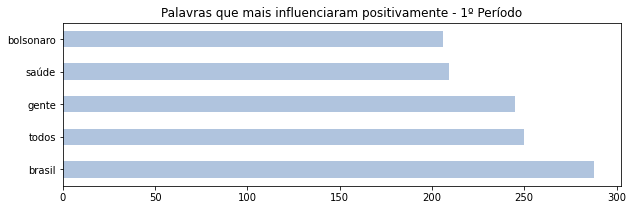

In [22]:
title = 'Palavras que mais influenciaram positivamente - 1º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos1')
fresults.generate_bar_from_tokens(all_tokens_pos, 5, 'lightsteelblue', 10, 3, title)

- Cidades com maiores médias de sentimentos

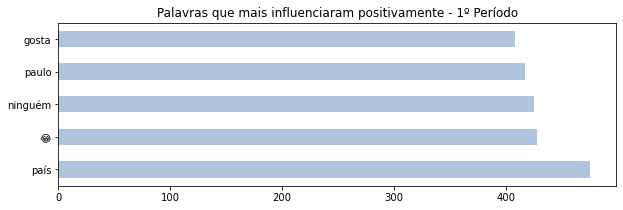

In [23]:
title = 'Palavras que mais influenciaram positivamente - 1º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos1')
fresults.generate_bar_from_tokens(all_tokens_pos, 5, 'lightsteelblue', 10, 3, title)

Segundo Período (Após 1º caso)

- Cidades com menores médias de sentimentos

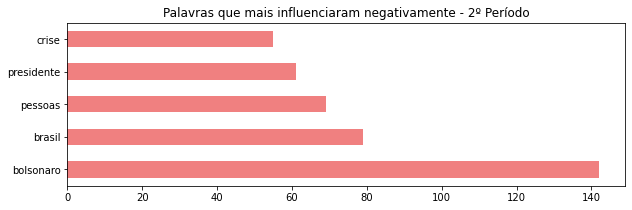

In [24]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg2')
fresults.generate_bar_from_tokens(all_tokens_neg, 5, 'lightcoral', 10, 3, title)

- Cidades com maiores médias de sentimentos

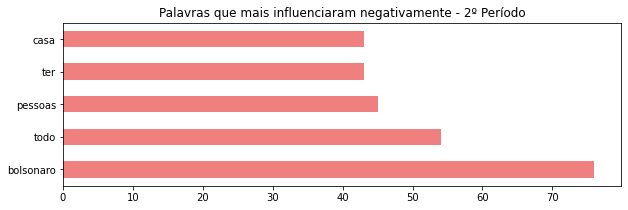

In [25]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg2')
fresults.generate_bar_from_tokens(all_tokens_neg, 5, 'lightcoral', 10, 3, title)

- Cidades com menores médias de sentimentos

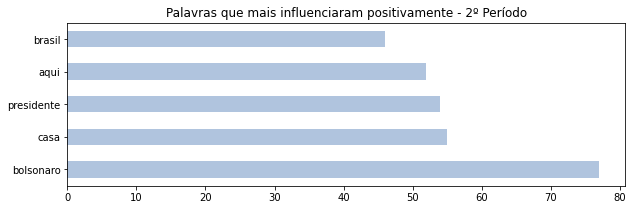

In [26]:
title = 'Palavras que mais influenciaram positivamente - 2º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos2')
fresults.generate_bar_from_tokens(all_tokens_pos, 5, 'lightsteelblue', 10, 3, title)

- Cidades com maiores médias de sentimentos

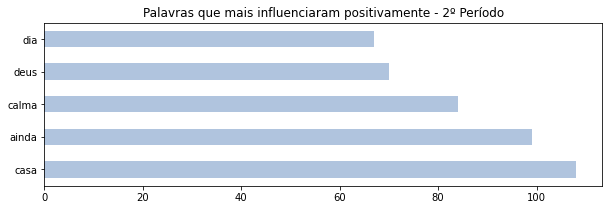

In [27]:
title = 'Palavras que mais influenciaram positivamente - 2º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos2')
fresults.generate_bar_from_tokens(all_tokens_pos, 5, 'lightsteelblue', 10, 3, title)

Terceiro Período (Após 1ª morte)

- Cidades com menores médias de sentimentos

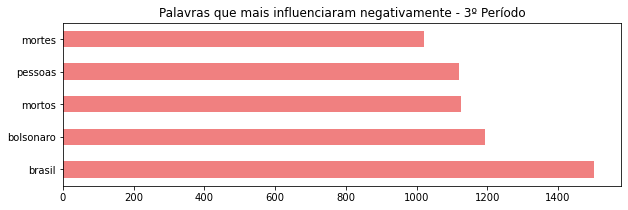

In [28]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg3')
fresults.generate_bar_from_tokens(all_tokens_neg, 5, 'lightcoral', 10, 3, title)

- Cidades com maiores médias de sentimentos

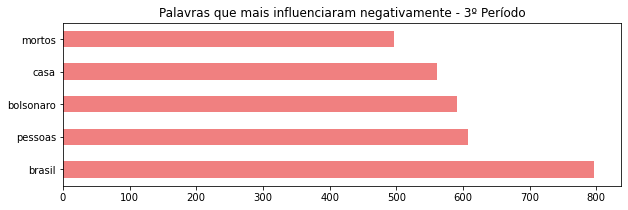

In [29]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg3')
fresults.generate_bar_from_tokens(all_tokens_neg, 5, 'lightcoral', 10, 3, title)

- Cidades com menores médias de sentimentos

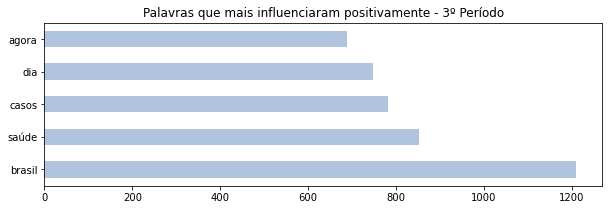

In [30]:
title = 'Palavras que mais influenciaram positivamente - 3º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos3')
fresults.generate_bar_from_tokens(all_tokens_pos, 5, 'lightsteelblue', 10, 3, title)

- Cidades com maiores médias de sentimentos

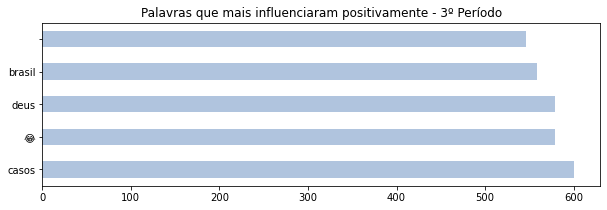

In [31]:
title = 'Palavras que mais influenciaram positivamente - 3º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos3')
fresults.generate_bar_from_tokens(all_tokens_pos, 5, 'lightsteelblue', 10, 3, title)